In [1]:
"""
conda create -n diffusion python=3.12
conda activate diffusion
conda install pip
pip install torch torchvision datasets einops
conda env export > environment.yml
"""
%load_ext autoreload
%autoreload 2

In [ ]:
import random

import numpy as np
import torch
from datasets import load_dataset
from torch.optim import Adam
from tqdm import tqdm

from backward import p_losses, p_refine, sample
from data import get_dataloader
from forward import get_noisy_image
from nn import Unet
from utils import DiffusionConstants, tensor_to_PIL

seed = 1
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

path = "ylecun/mnist"
split = "train[:10%]"
image_column = "image"
column_filter = None # Put something like ("label", 5) to only generate images with label 5
image_size = 32
channels = 1 # If you want to use RGB, change this to 3 and also change utils.PIL_to_tensor to convert to RGB
timesteps = 256
constants = DiffusionConstants(timesteps=timesteps)
batch_size = 128
epochs = 128
device = "cuda:6" if torch.cuda.is_available() else "cpu"


/home/vrim/miniconda3/envs/diffusion/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
print("Display the first image from the dataset.")
load_dataset(path, split="train[0:1]")[0][image_column]

Display the first image from the dataset.


Get a dataloader with desired images.


Map: 100%|██████████| 6000/6000 [00:01<00:00, 3079.87 examples/s]


len(dataloader) = 47

Batch should have shape (batch_size, channels, height, width)
batch.shape = torch.Size([128, 1, 32, 32])

Values should be between -1 and 1
batch.min() = tensor(-1.)
batch.max() = tensor(1.)

The reconstructed image


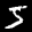

In [4]:
print("Get a dataloader with desired images.")
dataloader = get_dataloader(
    path,
    split=split,
    resize=(image_size, image_size),
    image_column=image_column,
    column_filter=column_filter,
    batch_size=batch_size,
    shuffle=False,
)
print(f"{len(dataloader) = }")

batch = next(iter(dataloader))
print("\nBatch should have shape (batch_size, channels, height, width)")
print(f"{batch.shape = }")

center_x, center_y = batch.shape[2] // 2, batch.shape[3] // 2
print("\nValues should be between -1 and 1")
print(f"{batch.min() = }")
print(f"{batch.max() = }")

image = tensor_to_PIL(batch[0])
print("\nThe reconstructed image")
display(image)


Get a noisy image at time step 0.


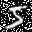

Get a noisy image at time step 64.


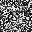

Get a noisy image at time step 128.


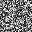

Get a noisy image at time step 192.


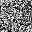

In [5]:
for t in [0, (1 * timesteps) // 4, (2 * timesteps) // 4, (3 * timesteps) // 4]:
    print(f"Get a noisy image at time step {t}.")
    display(get_noisy_image(batch[0], torch.Tensor([t]).to(torch.int64), constants))

In [6]:
model = Unet(
    dim=image_size,
    channels=channels,
    dim_mults=(1, 2, 4),
)
model.to(device)

optimizer = Adam(model.parameters(), lr=5e-4)

pbar = tqdm(total=len(dataloader) * epochs)
for epoch in range(epochs):
    for step, batch in enumerate(dataloader):
        optimizer.zero_grad()

        batch_size = batch.shape[0]
        batch = batch.to(device)

        # Algorithm 1 line 3: sample t uniformally for every example in the batch
        t = torch.randint(0, timesteps, (batch_size,), device=device).long()

        loss = p_losses(model, batch, t, constants=constants)

        pbar.update(1)
        pbar.set_description(f"Epoch {epoch + 1:3}/{epochs:3}, loss {loss.item():10.6f}")

        loss.backward()
        optimizer.step()
pbar.close()


Epoch 128/128, loss   0.015393: 100%|██████████| 6016/6016 [08:10<00:00, 12.26it/s]


In [7]:
samples = sample(
    model,
    image_size=image_size,
    batch_size=1,
    channels=channels,
    constants=constants,
)
print(f"{len(samples) = }")
print(f"{samples[0].shape = }")


sampling loop time step: 100%|██████████| 256/256 [00:04<00:00, 59.31it/s]

len(samples) = 256
samples[0].shape = torch.Size([1, 1, 32, 32])


Images at 10% intervals


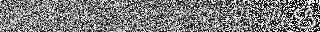

The last 10 images


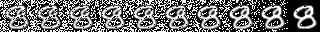

In [8]:
print("Images at 10% intervals")
images = []
for i in range(10):
    images.append(samples[i * timesteps // 10][0])
display(tensor_to_PIL(torch.cat(images, dim=2)))

print("The last 10 images")
images = []
for i in range(timesteps - 10, timesteps):
    images.append(samples[i][0])
display(tensor_to_PIL(torch.cat(images, dim=2)))

refine loop time step:   0%|          | 0/1 [00:00<?, ?it/s]

refine loop time step: 100%|██████████| 1/1 [00:00<00:00, 54.77it/s]


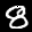

In [10]:
refined_image = p_refine(
    img=samples[-1],
    steps=1,
    model=model,
    shape=(1, channels, image_size, image_size),
    constants=constants,
)
display(tensor_to_PIL(refined_image[0]))